In [1]:
%config Completer.use_jedi=False

In [97]:
import torch
from torch import nn
from math import ceil

In [98]:
base_model=[
    #expand_ratio,channels,repeats,stride,kernel_size
    [1,16,1,1,3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

In [99]:
phi_values={
    #tupels of :(phi_value,resolution,drop_rate)
    'b0':(0,224,0.20),#alpha, beta, gamma, depth=alpha**phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [100]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))


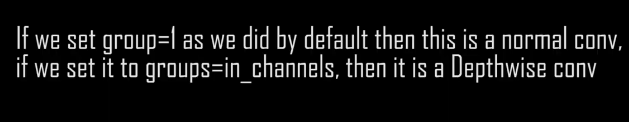

In [101]:
class SqueezeExcitation(nn.Module):
    def __init__(self,in_channels,reduced_dim):
        super(SqueezeExcitation,self).__init__()
        self.se=nn.Sequential(
        nn.AdaptiveAvgPool2d(1),#cxhxw -> cx1x1
        nn.Conv2d(in_channels,reduced_dim,1),
        nn.SiLU(),
        nn.Conv2d(reduced_dim,in_channels,1),
        nn.Sigmoid()
        )
    def forward(self,x):
        return x*self.se(x)#each channel will be mutliplayed it will give us ascore
#this class is  attention score
#it attenstion models that give us how much channel is prioritized 

In [102]:
class InvertedResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding,expand_ratio,
                reduction=4, #squeeze extension
                survival_prob=0.8):
        super(InvertedResidualBlock,self).__init__()
        self.survival_prob=survival_prob
        self.use_residual=in_channels==out_channels and stride==1
        hidden_dim=in_channels*expand_ratio
        self.expand=in_channels!=hidden_dim
        reduced_dim=int(in_channels/reduction)
        if self.expand:
            self.expand_conv=CNNBlock(in_channels,hidden_dim,kernel_size=3,stride=1,padding=1)
        self.conv=nn.Sequential(
        CNNBlock(hidden_dim,hidden_dim,kernel_size,stride,padding,groups=hidden_dim),
        SqueezeExtension(hidden_dim,reduced_dim),
        nn.Conv2d(hidden_dim,out_channels,1,bias=False),
        nn.BatchNorm2d(out_channels))
    def stochastic_depth(self,x):
        if not self.training:
            return x
        binary_tensor=torch.rand(x.shape[0],1,1,1,device=x.device)<self.survival_prob
        return torch.div(x,self.survival_prob)*binary_tensor#it just dropout but in layers
    #note they used torch.div() becouse iff we drop layer we need to handdel this weight
    def forward(self,inputs):
        x=self.expand_conv(inputs) if self.expand else inputs
        
        if self.use_residual:
            return self.stochastic_depth(self.conv(x))+inputs
        else:
            return self.conv(x)

In [103]:
class EfficientNet(nn.Module):
    def __init__(self,version,num_classes):
        super(EfficientNet,self).__init__()
        width_factor,depth_factor,drop_rate=self.calculate_factors(version)
        last_channels=ceil(1280*width_factor)
        self.pool=nn.AdaptiveAvgPool2d(1)
        self.features=self.create_features(width_factor,depth_factor,last_channels)
        self.classifer=nn.Sequential(nn.Dropout(drop_rate),
                                    nn.Linear(last_channels,num_classes))
    def calculate_factors(self,version,alpha=1.2,beta=1.1):
        phi,res,drop_rate=phi_values[version]
        depth_factor=alpha**phi
        width_factor=beta**phi
        return width_factor,depth_factor,drop_rate
    def create_features(self,width_factor,depth_factor,last_channels):
        channels=int(32*width_factor)
        features=[CNNBlock(3,channels,3,stride=2,padding=1)]
        in_channels=channels
        for expand_ratio,channels,repeats,stride,kernel_size in base_model:
            out_channels=4*ceil(int(channels*width_factor)/4)
            layers_repeats=ceil(repeats*depth_factor)
            for layer in range(layers_repeats):
                features.append(InvertedResidualBlock(
                in_channels,out_channels,expand_ratio=expand_ratio,
                stride=stride if layer==0 else 1,
                kernel_size=kernel_size,
                 padding=kernel_size//2)
                               )
                in_channels=out_channels
        features.append(CNNBlock(in_channels,last_channels,kernel_size=1,stride=1,padding=0))
        return nn.Sequential(*features)
   
    def forward(self,x):
        x=self.features(x)
        x=self.pool(x)
        return self.classifer(x.view(x.shape[0],-1))
                

In [104]:
def test():
    device='cpu' if torch.cuda.is_available() else "cpu"
    version='b0'
    phi,res,drop_rate=phi_values[version]
    num_examples,num_classes=4,10
    x=torch.rand((num_examples,3,res,res)).to(device)
    model=EfficientNet(version=version,num_classes=num_classes).to(device)
    print(model(x).shape)

In [105]:
test()

torch.Size([4, 10])


In [19]:
# m = nn.AdaptiveAvgPool2d(7)
# hh = torch.randn(1, 64, 10, 9)
# output = m(hh)
# output.shape
# #torch.Size([1, 64, 7, 7])

In [21]:
# m = nn.AvgPool2d(2)
# hh = torch.randn(1, 64, 10, 9)
# output = m(hh)
# output.shape
# #torch.Size([1, 64, 5, 4])

torch.Size([1, 64, 5, 4])